<a href="https://colab.research.google.com/github/pichayaanik/Capstone_PichayaAnik/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Discovering Key-Drivers for Boosting Thailand's Digital Competitiveness Index Using an NLP Approach**
---
Pichaya Charoonpongsakdi (Anik) <br>
GA-TDA DSI Capstone Project

# Part 1: Problem Statement
---

#Part 2: Data Wrangling
---


##2.0 Install and Import Libraries

In [1]:
# Install pythainlp library
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 7.7 MB/s 


In [2]:
# Import Basic Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Sklearn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import NLP Libraries
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from pythainlp.tokenize import sent_tokenize, word_tokenize
from pythainlp.corpus import thai_stopwords
import re

In [3]:
# Download TH Sarabun (Thai font)
!gdown 1rZSpiIh6fTeaDPOCKvamgtlR3qN2UQEl

Downloading...
From: https://drive.google.com/uc?id=1rZSpiIh6fTeaDPOCKvamgtlR3qN2UQEl
To: /content/THSarabunNew.ttf
100% 474k/474k [00:00<00:00, 79.4MB/s]


In [4]:
# Set TH Sarabun as default Thai font
mpl.font_manager.fontManager.addfont('/content/THSarabunNew.ttf')
mpl.rc('font', family='TH Sarabun New', size=20)

##2.1 Load Datasets

In [5]:
# Download datasets from Google Drive
!gdown 1BQtzBne72ML1OoJG46IbYQ_v9pUrOq1K

Downloading...
From: https://drive.google.com/uc?id=1BQtzBne72ML1OoJG46IbYQ_v9pUrOq1K
To: /content/bkkbiz_update.json
100% 2.29G/2.29G [00:20<00:00, 111MB/s]


In [6]:
# Import datasets
bkkbiz = pd.read_json('/content/bkkbiz_update.json')

In [7]:
# Check head
bkkbiz.head()

,ID,date,category,title,description,article,url
0,620001,2014-11-27 08:01:00,ต่างประเทศ,น้ำมันดิบปิดร่วง-คาดโอเปคไม่ลดกำลังผลิต,น้ำมันดิบปิดร่วงแตะระดับต่ำสุดในรอบ 4 ปี-คาดโอ...,สัญญาน้ำมันดิบตลาดล่วงหน้าสหรัฐ ปิดตลาดปรับตัว...,https://www.bangkokbiznews.com/news/detail/620001
1,620002,2014-11-27 08:20:00,ต่างประเทศ,ทองคำปิดร่วงหลังสหรัฐเผยข้อมูลเศรษฐกิจ,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,https://www.bangkokbiznews.com/news/detail/620002
2,620009,2014-11-27 09:34:00,การเงิน-การลงทุน,"ทองแท่งขายออก18,600บ.ไม่เปลี่ยนแปลง","ราคาทองคำวันนี้ทองแท่งขายออกบาทละ 18,600 บาท ท...",สมาคมค้าทองคำรายงานราคาทอง 96.5% ประจำวันที่ 2...,https://www.bangkokbiznews.com/news/detail/620009
3,620010,2014-11-27 09:36:00,การเงิน-การลงทุน,เงินบาทเปิด32.75/77คาดแกว่งแคบ,ค่าเงินบาทเปิดที่ 32.75/77 บาท/ดอลลาร์ คาดแกว่...,นักบริหารเงินจากธนาคารพาณิชย์ เปิดเผยว่า เงินบ...,https://www.bangkokbiznews.com/news/detail/620010
4,620011,2014-11-27 09:48:00,การเงิน-การลงทุน,คาดหุ้นเช้าแกว่งไซด์เวย์,โบรกฯ คาดหุ้นเช้านี้แกว่งไซด์เวย์ช่วงไร้ปัจจัย...,นายอภิชาติ ผู้บรรเจิดกุล ผู้อำนวยการสายงานวิเค...,https://www.bangkokbiznews.com/news/detail/620011


##2.2 Data Cleaning


In [10]:
# Check shape
bkkbiz.shape

(361228, 7)

In [8]:
# Convert column heads to lower case
bkkbiz.columns.str.lower()

Index(['id', 'date', 'category', 'title', 'description', 'article', 'url'], dtype='object')

In [9]:
# Check dtypes
bkkbiz.dtypes

ID                      int64
date           datetime64[ns]
category               object
title                  object
description            object
article                object
url                    object
dtype: object

In [11]:
# Check nulls
bkkbiz.isnull().sum()

ID             0
date           0
category       0
title          0
description    0
article        0
url            0
dtype: int64

In [12]:
# Check duplicate rows
set([bkkbiz['title'].value_counts().count(),
     bkkbiz['description'].value_counts().count(), 
     bkkbiz['article'].value_counts().count(), 
     bkkbiz.shape[0]])

{337402, 352490, 354923, 361228}

In [13]:
# Check deplicates
bkkbiz['article'].value_counts().count(), bkkbiz['article'].isnull().sum()

(337402, 0)

#EDA - overall
---

In [14]:
bkkbiz.columns

Index(['ID', 'date', 'category', 'title', 'description', 'article', 'url'], dtype='object')

In [15]:
# Number of article in each subcategory
bkkbiz['category'].value_counts().sort_values(ascending=False)

การเมือง              105331
การเงิน-การลงทุน       55041
ต่างประเทศ             42309
เศรษฐกิจ               35453
ไลฟ์สไตล์              24044
คุณภาพชีวิต-สังคม      18520
การเงิน                17742
ธุรกิจ                 16344
ทั่วไป                 15901
Data Analysis           3630
หุ้น                    3240
สาธารณสุข               2560
ประชาสัมพันธ์           2474
IT & gadget             1964
คอลัมนิสต์              1609
Bizweek                 1541
ข่าวพระราชสำนัก         1333
อสังหาริมทรัพย์         1331
ข่าวในพระราชสำนัก       1292
บันเทิง                 1286
นวัตกรรม                1191
@Taste                  1065
จุดประกาย                747
สุขภาพ-คุณภาพชีวิต       680
ท่องเที่ยว               582
ยานยนต์                  552
Art & living             545
การศึกษา                 487
ข่าวทั่วไป               406
สิ่งแวดล้อม              373
ดูดวง                    336
แรงงาน                   305
เศรษฐกิจ-ธุรกิจ          209
Corporate Moves          207
CEO Blog      

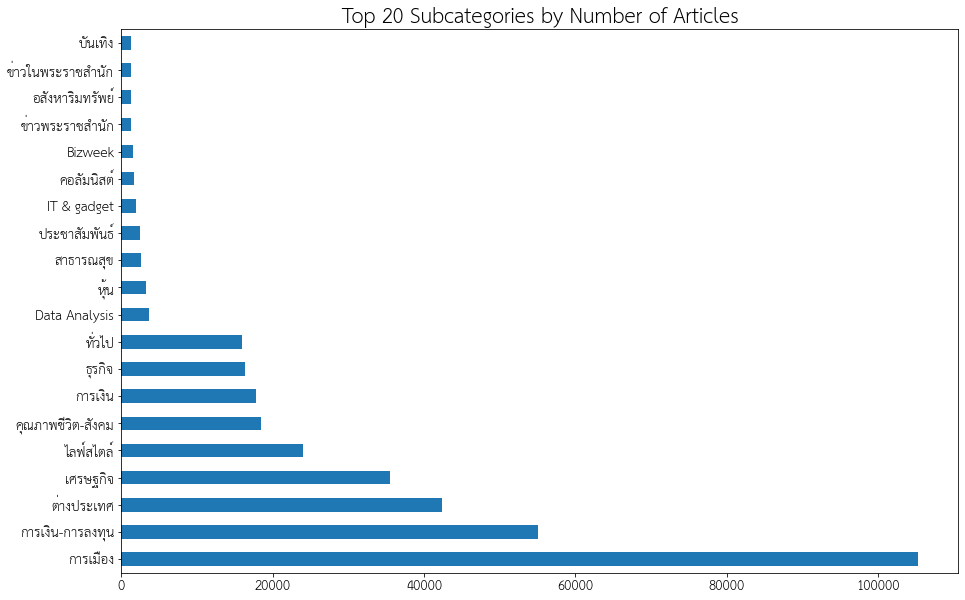

In [19]:
# Top 20 subcategories by number of articles
plt.figure(figsize=(15,10))
plt.title('Top 20 Subcategories by Number of Articles', size=30)
bkkbiz['category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh');

In [23]:
# Time released
bkkbiz['date'].dt.year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [28]:
# Number of Article by Year
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count()

date
2014     4646
2015    51297
2016    25825
2017    51332
2018    34992
2019    36653
2020    53321
2021    63939
2022    39223
Name: title, dtype: int64

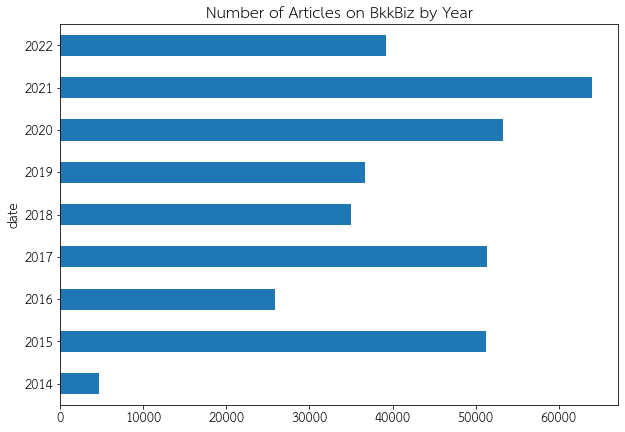

In [35]:
# Number of Article by Year
plt.figure(figsize=(10,7))
plt.title('Number of Articles on BkkBiz by Year')
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count().plot(kind='barh');

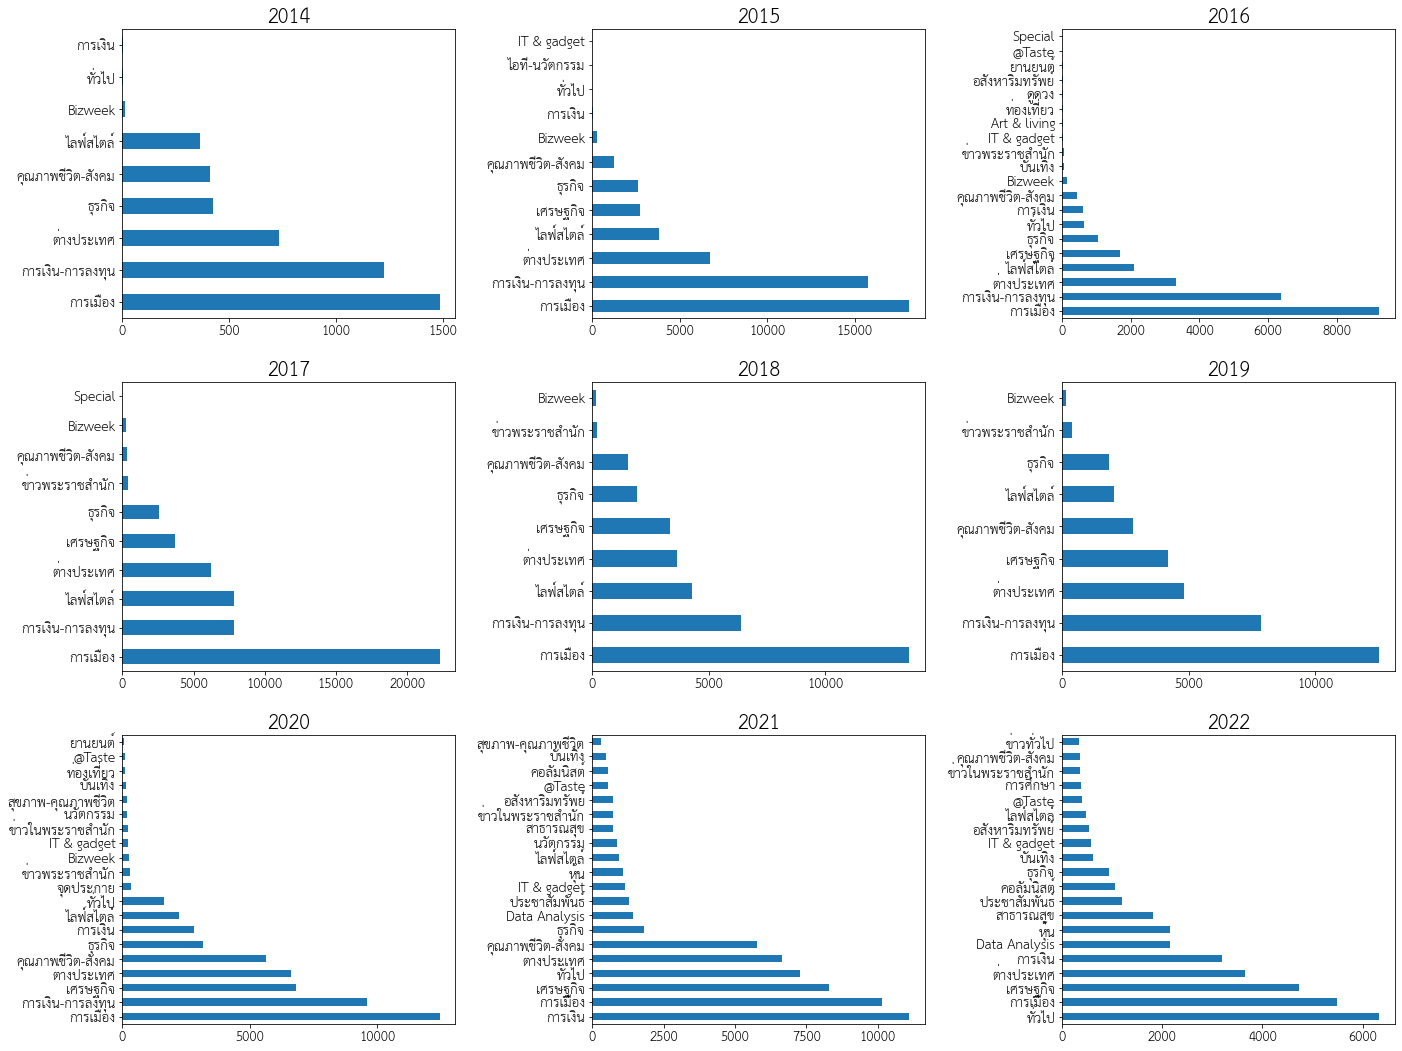

In [78]:
# Number of articles by category by year
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

fig, axs = plt.subplots(3,3, figsize=(20,15), sharex=True)
for n, year in enumerate(years):
  plt.subplot(3,3,n+1)
  plt.title(year, size=30)
  plt.tight_layout()
  bkkbiz[bkkbiz['date'].dt.year==year]['category'].value_counts().head(20).plot(kind='barh');

In [79]:
# Check 2019
bkkbiz[bkkbiz['date'].dt.year==2019]['category'].value_counts().head(20)

การเมือง             12517
การเงิน-การลงทุน      7857
ต่างประเทศ            4821
เศรษฐกิจ              4194
คุณภาพชีวิต-สังคม     2812
ไลฟ์สไตล์             2041
ธุรกิจ                1861
ข่าวพระราชสำนัก        388
Bizweek                162
Name: category, dtype: int64

In [ ]:
# Call only category that exists across 9 years
bkkbiz

In [94]:
bkkbiz[bkkbiz['date'].dt.year]['category'].nunique()

KeyError: ignored

In [ ]:
# Number of articles in each subcats


In [ ]:
# Length of article in each cats

#Pre-Processing
---

##2.3 Preprocessing

ลองเฉพาะหมวด econ ก่อน

In [ ]:
bkkbiz['category'].unique()

array(['ต่างประเทศ', 'การเงิน-การลงทุน', 'การเมือง', 'คุณภาพชีวิต-สังคม',
       'ธุรกิจ', 'ไลฟ์สไตล์', 'Bizweek', 'ทั่วไป', 'การเงิน', 'เศรษฐกิจ',
       'ไอที-นวัตกรรม', 'IT & gadget', 'ท่องเที่ยว', 'Art & living',
       'บันเทิง', 'ยานยนต์', 'อสังหาริมทรัพย์', 'ดูดวง', '@Taste',
       'ข่าวพระราชสำนัก', 'Special', 'จุดประกาย', 'Data Analysis',
       'ข่าวในพระราชสำนัก', 'นวัตกรรม', 'สุขภาพ-คุณภาพชีวิต',
       'สิ่งแวดล้อม', 'ข่าวทั่วไป', 'เศรษฐกิจ-ธุรกิจ', 'ประชาสัมพันธ์',
       'CEO Blog', 'คอลัมนิสต์', 'การศึกษา', 'ความงาม-แฟชั่น',
       'Training Course', 'Biz2U', 'หุ้น', 'Corporate Moves', 'ลอตเตอรี่',
       'สาธารณสุข', 'แรงงาน', 'เทคโนโลยี', 'คุณภาพชีวิต'], dtype=object)

In [ ]:
# Create economics news DataFrame
econ = bkkbiz[bkkbiz['category']=='เศรษฐกิจ'].reset_index(drop=True)

In [ ]:
# Recheck
econ.shape

(35453, 7)

In [ ]:
# Recheck 
econ.head()

,ID,date,category,title,description,article,url
0,632149,2015-01-30 18:20:00,เศรษฐกิจ,ซีพีเอฟร่วมลดก๊าซเรือนกระจก,ซีพีเอฟ ลงนามความร่วมมือโครงการต้นแบบลดก๊าซเรื...,นายสุนันต์ อรุณนพรัตน์(ที่ 4 จากซ้าย) ผู้ช่วยร...,https://www.bangkokbiznews.com/news/detail/632149
1,632695,2015-02-03 16:30:00,เศรษฐกิจ,จับตายักษ์ใหญ่คว้า'โซลาร์'กองทัพบก,"จับตายักษ์ใหญ่คว้า""โซลาร์""กองทัพบก ปูดบ.รีนิวเ...",รายงานข่าวจากวงการพลังงาน เปิดเผยว่า จากการที่...,https://www.bangkokbiznews.com/news/detail/632695
2,633724,2015-02-09 10:03:00,เศรษฐกิจ,หวั่น'ส่งออก'ทรุดต่อเนื่อง,นักเศรษฐศาสตร์-นักการเงิน ห่วงส่งออกไทยหดตัวต่...,"""กอบศักดิ์"" ชี้เงินบาทแข็งเกินพื้นฐาน ด้าน ""ตี...",https://www.bangkokbiznews.com/news/detail/633724
3,633727,2015-02-09 10:20:00,เศรษฐกิจ,จี้'แบงก์รัฐ'ดันแพ็คเกจแก้จน,"กระทรวงคลัง เผย ""แบงก์รัฐ"" เร่งทำโครงการช่วยเห...",แหล่งข่าวจากกระทรวงการคลัง เปิดเผยว่า สถาบันกา...,https://www.bangkokbiznews.com/news/detail/633727
4,633738,2015-02-09 11:02:00,เศรษฐกิจ,ดอลลาร์แข็งฉุด'หนี้นอก'ลด,"""แบงก์ชาติ"" เผยอดหนี้ต่างประเทศเดือนธ.ค. รวมกว...",รายงานข่าวจากธนาคารแห่งประเทศไทย (ธปท.) เปิดเผ...,https://www.bangkokbiznews.com/news/detail/633738


In [ ]:
# Create function
def tokenize(txt):
  
  ''' 
  Definition:
  A function that returns tokenized words with stop words and other regular expressions 
  that do not match English and Thai alphabets removed

  Parameters:
  - txt = text string
  '''

  stopwords = thai_stopwords()
  tokens = word_tokenize(txt, keep_whitespace = False)
  tokens = [token for token in tokens if token not in stopwords]
  tokens = [token for token in tokens if re.match(r'[A-Za-zก-ฮ]+', token)]
  return tokens

In [ ]:
# Tokenize & remove stopwords
column_list = ['title', 'description', 'article']

for column in column_list:
  econ[column + '_tokenize'] = econ[column].apply(tokenize)

In [ ]:
# Recheck
econ

,ID,date,category,title,description,article,url,title_tokenize,description_tokenize,article_tokenize
0,632149,2015-01-30 18:20:00,เศรษฐกิจ,ซีพีเอฟร่วมลดก๊าซเรือนกระจก,ซีพีเอฟ ลงนามความร่วมมือโครงการต้นแบบลดก๊าซเรื...,นายสุนันต์ อรุณนพรัตน์(ที่ 4 จากซ้าย) ผู้ช่วยร...,https://www.bangkokbiznews.com/news/detail/632149,"[ซี, พี, ลด, ก๊าซ]","[ซี, พี, ลงนาม, ความร่วมมือ, ต้นแบบ, ลด, ก๊าซ,...","[สุ, นันต์, อรุณ, นพรัตน์, ซ้าย, ผู้ช่วย, รัฐม..."
1,632695,2015-02-03 16:30:00,เศรษฐกิจ,จับตายักษ์ใหญ่คว้า'โซลาร์'กองทัพบก,"จับตายักษ์ใหญ่คว้า""โซลาร์""กองทัพบก ปูดบ.รีนิวเ...",รายงานข่าวจากวงการพลังงาน เปิดเผยว่า จากการที่...,https://www.bangkokbiznews.com/news/detail/632695,"[จับตา, ยักษ์, คว้า, กองทัพบก]","[จับตา, ยักษ์, คว้า, กองทัพบก, ปูด, บ., รี, นิ...","[รายงาน, ข่าว, วงการ, พลังงาน, กองทัพบก, ทำหนั..."
2,633724,2015-02-09 10:03:00,เศรษฐกิจ,หวั่น'ส่งออก'ทรุดต่อเนื่อง,นักเศรษฐศาสตร์-นักการเงิน ห่วงส่งออกไทยหดตัวต่...,"""กอบศักดิ์"" ชี้เงินบาทแข็งเกินพื้นฐาน ด้าน ""ตี...",https://www.bangkokbiznews.com/news/detail/633724,"[หวั่น, ส่งออก, ทรุด, ต่อเนื่อง]","[นักเศรษฐศาสตร์, การเงิน, ห่วง, ส่งออก, หดตัว,...","[กอบ, ศักดิ์, ชี้, พื้นฐาน, ตี, รณ, ห่วง, ติดล..."
3,633727,2015-02-09 10:20:00,เศรษฐกิจ,จี้'แบงก์รัฐ'ดันแพ็คเกจแก้จน,"กระทรวงคลัง เผย ""แบงก์รัฐ"" เร่งทำโครงการช่วยเห...",แหล่งข่าวจากกระทรวงการคลัง เปิดเผยว่า สถาบันกา...,https://www.bangkokbiznews.com/news/detail/633727,"[จี้, รัฐ, ดัน]","[กระทรวง, คลัง, รัฐ, ทำ, ช่วยเหลือ, คนจน, ลด, ...","[กระทรวงการคลัง, สถาบันการเงิน, รัฐ, ธนาคารเพื..."
4,633738,2015-02-09 11:02:00,เศรษฐกิจ,ดอลลาร์แข็งฉุด'หนี้นอก'ลด,"""แบงก์ชาติ"" เผยอดหนี้ต่างประเทศเดือนธ.ค. รวมกว...",รายงานข่าวจากธนาคารแห่งประเทศไทย (ธปท.) เปิดเผ...,https://www.bangkokbiznews.com/news/detail/633738,"[ดอลลาร์, ฉุด, หนี้]","[ชาติ, ยอด, หนี้, ต่างประเทศ, ธ.ค., ล้าน, ดอลล...","[รายงาน, ข่าว, ธนาคารแห่งประเทศไทย, ธปท., หนี้..."
...,...,...,...,...,...,...,...,...,...,...
35448,1019949,2022-08-09 15:28:00,เศรษฐกิจ,ครม.ไฟเขียวแผนปฏิบัติการพัฒนาภาคเกษตรในอีอีซี ...,ครม.เห็นชอบร่างแผนปฏิบัติการพัฒนาการเกษตรในเขต...,นางสาวรัชดา ธนาดิเรก รองโฆษกประจำสำนักนายกรัฐม...,https://www.bangkokbiznews.com/news/detail/101...,"[ครม., การพัฒนา, อี, อีซี, ปี]","[ครม., ร่าง, การพัฒนา, การเกษตร, EEC, ปี, ชู, ...","[รัชดา, ธนา, ดิเรก, รอง, ประจำ, สำนักนายกรัฐมน..."
35449,1019952,2022-08-09 15:37:00,เศรษฐกิจ,ครม.เคาะสิทธิประโยชน์เมืองการบินภาคตะวันออก ดั...,"""ครม."" เคาะ! ชุดสิทธิประโยชน์ในเขตส่งเสริมเศรษ...",นางสาวรัชดา ธนาดิเรก รองโฆษกประจำสำนักนายกรัฐม...,https://www.bangkokbiznews.com/news/detail/101...,"[ครม., สิทธิประโยชน์, บิน, ตะวันออก, ดัน]","[ครม., ชุด, สิทธิประโยชน์, ส่งเสริม, พิเศษ, บิ...","[รัชดา, ธนา, ดิเรก, รอง, ประจำ, สำนักนายกรัฐมน..."
35450,1019968,2022-08-09 16:29:00,เศรษฐกิจ,'อาเซียน-จีน' จับมืออัพเกรดเอฟทีเอ ตั้งเป้าประ...,'อาเซียน-จีน' เดินหน้ายกระดับความตกลง ACFTA ให...,นางสาวโชติมา เอี่ยมสวัสดิกุล รองอธิบดีกรมเจรจา...,https://www.bangkokbiznews.com/news/detail/101...,"[อาเซียน, จีน, จับมือ, อัพเกรด, ตั้งเป้า, ประก...","[อาเซียน, จีน, ยกระดับ, ความตกลง, ACFTA, ทันสม...","[สวัสดิ, กุล, รองอธิบดี, กรม, การค้า, ระหว่างป..."
35451,1019975,2022-08-09 17:09:00,เศรษฐกิจ,"""ราคาน้ำมันพรุ่งนี้ 2565"" 10 ส.ค. 65 อัปเดตราค...","""ราคาน้ำมันพรุ่งนี้ 2565 ล่าสุด"" 10 ส.ค. 65 เช...","""ราคาน้ำมันพรุ่งนี้ 2565 ล่าสุด"" อัปเดตข้อมูล ...",https://www.bangkokbiznews.com/news/detail/101...,"[ราคา, น้ำมัน, พรุ่งนี้, ส.ค., อัปเดต, ราคา, น...","[ราคา, น้ำมัน, พรุ่งนี้, ส.ค., ราคา, น้ำมัน, ท...","[ราคา, น้ำมัน, พรุ่งนี้, อัปเดต, ข้อมูล, วันที..."


#Part 3: Exploratory Data Analysis (EDA)
---

##3.1 Overall

In [ ]:
# Write word_count() function
cols = ['title', 'description', 'article']

for col in cols:
  bkkbiz[col+'_word_count'] = bkkbiz[col].str.split().str.len()

In [ ]:
bkkbiz.head()

,ID,date,category,title,description,article,url,title_word_count,description_word_count,article_word_count
0,620001,2014-11-27 08:01:00,ต่างประเทศ,น้ำมันดิบปิดร่วง-คาดโอเปคไม่ลดกำลังผลิต,น้ำมันดิบปิดร่วงแตะระดับต่ำสุดในรอบ 4 ปี-คาดโอ...,สัญญาน้ำมันดิบตลาดล่วงหน้าสหรัฐ ปิดตลาดปรับตัว...,https://www.bangkokbiznews.com/news/detail/620001,1,3,47
1,620002,2014-11-27 08:20:00,ต่างประเทศ,ทองคำปิดร่วงหลังสหรัฐเผยข้อมูลเศรษฐกิจ,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,https://www.bangkokbiznews.com/news/detail/620002,1,3,31
2,620009,2014-11-27 09:34:00,การเงิน-การลงทุน,"ทองแท่งขายออก18,600บ.ไม่เปลี่ยนแปลง","ราคาทองคำวันนี้ทองแท่งขายออกบาทละ 18,600 บาท ท...",สมาคมค้าทองคำรายงานราคาทอง 96.5% ประจำวันที่ 2...,https://www.bangkokbiznews.com/news/detail/620009,1,7,29
3,620010,2014-11-27 09:36:00,การเงิน-การลงทุน,เงินบาทเปิด32.75/77คาดแกว่งแคบ,ค่าเงินบาทเปิดที่ 32.75/77 บาท/ดอลลาร์ คาดแกว่...,นักบริหารเงินจากธนาคารพาณิชย์ เปิดเผยว่า เงินบ...,https://www.bangkokbiznews.com/news/detail/620010,1,8,46
4,620011,2014-11-27 09:48:00,การเงิน-การลงทุน,คาดหุ้นเช้าแกว่งไซด์เวย์,โบรกฯ คาดหุ้นเช้านี้แกว่งไซด์เวย์ช่วงไร้ปัจจัย...,นายอภิชาติ ผู้บรรเจิดกุล ผู้อำนวยการสายงานวิเค...,https://www.bangkokbiznews.com/news/detail/620011,1,2,50


NameError: ignored

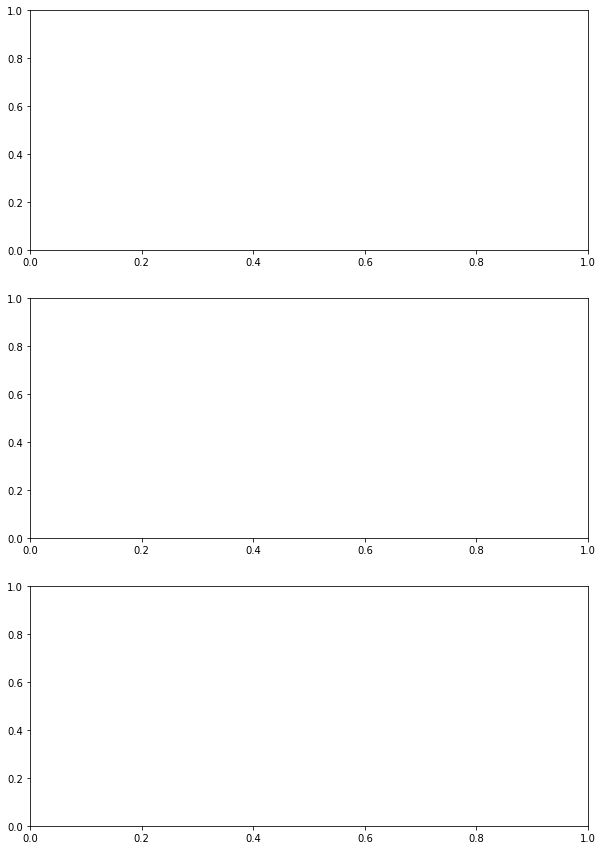

In [ ]:
# Plot word count with histogram

# Word_count column list


# Set subplots
fig, ax = plt.subplots(3, 1, figsize=(10,15))

# Create histogram of each word count columns by looping
for n, col in enumerate(cols_word_count):
    sns.histplot(data=df, 
                 x=col, 
                 bins=30, 
                 color='salmon', 
                 ax=ax[n]).\
                set_title(col, size=20)

plt.tight_layout()

##3.2 Econ Corpus

In [ ]:
word_tokenize(econ['title'][0] ,keep_whitespace=False)

['ซี', 'พี', 'เอฟ', 'ร่วม', 'ลด', 'ก๊าซ', 'เรือนกระจก']

In [ ]:
def tokenize_2():
  return len(word_tokenize(econ['title'] ,keep_whitespace=False))

In [ ]:
len(econ['title'][0].split())

1

In [ ]:
econ['title'][0].split()

['ซีพีเอฟร่วมลดก๊าซเรือนกระจก']

In [ ]:
column_list = ['title', 'description', 'article']

for column in column_list:
  econ[column+'_count'] = econ[column].apply(lambda x: len(word_tokenize(x, keep_whitespace=False)))

In [ ]:
econ['title_count'] = econ['title'].apply(lambda x: len(word_tokenize(x, keep_whitespace=False)))

In [ ]:
econ

,ID,date,category,title,description,article,url,title_tokenize,description_tokenize,article_tokenize,title_count,description_count,article_count
0,632149,2015-01-30 18:20:00,เศรษฐกิจ,ซีพีเอฟร่วมลดก๊าซเรือนกระจก,ซีพีเอฟ ลงนามความร่วมมือโครงการต้นแบบลดก๊าซเรื...,นายสุนันต์ อรุณนพรัตน์(ที่ 4 จากซ้าย) ผู้ช่วยร...,https://www.bangkokbiznews.com/news/detail/632149,"[ซี, พี, ลด, ก๊าซ]","[ซี, พี, ลงนาม, ความร่วมมือ, ต้นแบบ, ลด, ก๊าซ,...","[สุ, นันต์, อรุณ, นพรัตน์, ซ้าย, ผู้ช่วย, รัฐม...",7,13,111
1,632695,2015-02-03 16:30:00,เศรษฐกิจ,จับตายักษ์ใหญ่คว้า'โซลาร์'กองทัพบก,"จับตายักษ์ใหญ่คว้า""โซลาร์""กองทัพบก ปูดบ.รีนิวเ...",รายงานข่าวจากวงการพลังงาน เปิดเผยว่า จากการที่...,https://www.bangkokbiznews.com/news/detail/632695,"[จับตา, ยักษ์, คว้า, กองทัพบก]","[จับตา, ยักษ์, คว้า, กองทัพบก, ปูด, บ., รี, นิ...","[รายงาน, ข่าว, วงการ, พลังงาน, กองทัพบก, ทำหนั...",8,30,481
2,633724,2015-02-09 10:03:00,เศรษฐกิจ,หวั่น'ส่งออก'ทรุดต่อเนื่อง,นักเศรษฐศาสตร์-นักการเงิน ห่วงส่งออกไทยหดตัวต่...,"""กอบศักดิ์"" ชี้เงินบาทแข็งเกินพื้นฐาน ด้าน ""ตี...",https://www.bangkokbiznews.com/news/detail/633724,"[หวั่น, ส่งออก, ทรุด, ต่อเนื่อง]","[นักเศรษฐศาสตร์, การเงิน, ห่วง, ส่งออก, หดตัว,...","[กอบ, ศักดิ์, ชี้, พื้นฐาน, ตี, รณ, ห่วง, ติดล...",6,21,1423
3,633727,2015-02-09 10:20:00,เศรษฐกิจ,จี้'แบงก์รัฐ'ดันแพ็คเกจแก้จน,"กระทรวงคลัง เผย ""แบงก์รัฐ"" เร่งทำโครงการช่วยเห...",แหล่งข่าวจากกระทรวงการคลัง เปิดเผยว่า สถาบันกา...,https://www.bangkokbiznews.com/news/detail/633727,"[จี้, รัฐ, ดัน]","[กระทรวง, คลัง, รัฐ, ทำ, ช่วยเหลือ, คนจน, ลด, ...","[กระทรวงการคลัง, สถาบันการเงิน, รัฐ, ธนาคารเพื...",9,17,829
4,633738,2015-02-09 11:02:00,เศรษฐกิจ,ดอลลาร์แข็งฉุด'หนี้นอก'ลด,"""แบงก์ชาติ"" เผยอดหนี้ต่างประเทศเดือนธ.ค. รวมกว...",รายงานข่าวจากธนาคารแห่งประเทศไทย (ธปท.) เปิดเผ...,https://www.bangkokbiznews.com/news/detail/633738,"[ดอลลาร์, ฉุด, หนี้]","[ชาติ, ยอด, หนี้, ต่างประเทศ, ธ.ค., ล้าน, ดอลล...","[รายงาน, ข่าว, ธนาคารแห่งประเทศไทย, ธปท., หนี้...",7,23,722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35448,1019949,2022-08-09 15:28:00,เศรษฐกิจ,ครม.ไฟเขียวแผนปฏิบัติการพัฒนาภาคเกษตรในอีอีซี ...,ครม.เห็นชอบร่างแผนปฏิบัติการพัฒนาการเกษตรในเขต...,นางสาวรัชดา ธนาดิเรก รองโฆษกประจำสำนักนายกรัฐม...,https://www.bangkokbiznews.com/news/detail/101...,"[ครม., การพัฒนา, อี, อีซี, ปี]","[ครม., ร่าง, การพัฒนา, การเกษตร, EEC, ปี, ชู, ...","[รัชดา, ธนา, ดิเรก, รอง, ประจำ, สำนักนายกรัฐมน...",15,23,156
35449,1019952,2022-08-09 15:37:00,เศรษฐกิจ,ครม.เคาะสิทธิประโยชน์เมืองการบินภาคตะวันออก ดั...,"""ครม."" เคาะ! ชุดสิทธิประโยชน์ในเขตส่งเสริมเศรษ...",นางสาวรัชดา ธนาดิเรก รองโฆษกประจำสำนักนายกรัฐม...,https://www.bangkokbiznews.com/news/detail/101...,"[ครม., สิทธิประโยชน์, บิน, ตะวันออก, ดัน]","[ครม., ชุด, สิทธิประโยชน์, ส่งเสริม, พิเศษ, บิ...","[รัชดา, ธนา, ดิเรก, รอง, ประจำ, สำนักนายกรัฐมน...",11,23,234
35450,1019968,2022-08-09 16:29:00,เศรษฐกิจ,'อาเซียน-จีน' จับมืออัพเกรดเอฟทีเอ ตั้งเป้าประ...,'อาเซียน-จีน' เดินหน้ายกระดับความตกลง ACFTA ให...,นางสาวโชติมา เอี่ยมสวัสดิกุล รองอธิบดีกรมเจรจา...,https://www.bangkokbiznews.com/news/detail/101...,"[อาเซียน, จีน, จับมือ, อัพเกรด, ตั้งเป้า, ประก...","[อาเซียน, จีน, ยกระดับ, ความตกลง, ACFTA, ทันสม...","[สวัสดิ, กุล, รองอธิบดี, กรม, การค้า, ระหว่างป...",14,37,223
35451,1019975,2022-08-09 17:09:00,เศรษฐกิจ,"""ราคาน้ำมันพรุ่งนี้ 2565"" 10 ส.ค. 65 อัปเดตราค...","""ราคาน้ำมันพรุ่งนี้ 2565 ล่าสุด"" 10 ส.ค. 65 เช...","""ราคาน้ำมันพรุ่งนี้ 2565 ล่าสุด"" อัปเดตข้อมูล ...",https://www.bangkokbiznews.com/news/detail/101...,"[ราคา, น้ำมัน, พรุ่งนี้, ส.ค., อัปเดต, ราคา, น...","[ราคา, น้ำมัน, พรุ่งนี้, ส.ค., ราคา, น้ำมัน, ท...","[ราคา, น้ำมัน, พรุ่งนี้, อัปเดต, ข้อมูล, วันที...",18,35,84


In [ ]:
# article_tokenized_joined
# column_list = ['title', 'description', 'article']

#econ['title_tokenize_unlist'] = econ['title_tokenize'].split()

econ['title_tokenize_unlist'] = econ['title_tokenize'].apply(lambda x:' '.join(x))

In [ ]:
econ.head()

,ID,date,category,title,description,article,url,title_tokenize,description_tokenize,article_tokenize,title_count,description_count,article_count,title_tokenize_unlist
0,632149,2015-01-30 18:20:00,เศรษฐกิจ,ซีพีเอฟร่วมลดก๊าซเรือนกระจก,ซีพีเอฟ ลงนามความร่วมมือโครงการต้นแบบลดก๊าซเรื...,นายสุนันต์ อรุณนพรัตน์(ที่ 4 จากซ้าย) ผู้ช่วยร...,https://www.bangkokbiznews.com/news/detail/632149,"[ซี, พี, ลด, ก๊าซ]","[ซี, พี, ลงนาม, ความร่วมมือ, ต้นแบบ, ลด, ก๊าซ,...","[สุ, นันต์, อรุณ, นพรัตน์, ซ้าย, ผู้ช่วย, รัฐม...",7,13,111,ซี พี ลด ก๊าซ
1,632695,2015-02-03 16:30:00,เศรษฐกิจ,จับตายักษ์ใหญ่คว้า'โซลาร์'กองทัพบก,"จับตายักษ์ใหญ่คว้า""โซลาร์""กองทัพบก ปูดบ.รีนิวเ...",รายงานข่าวจากวงการพลังงาน เปิดเผยว่า จากการที่...,https://www.bangkokbiznews.com/news/detail/632695,"[จับตา, ยักษ์, คว้า, กองทัพบก]","[จับตา, ยักษ์, คว้า, กองทัพบก, ปูด, บ., รี, นิ...","[รายงาน, ข่าว, วงการ, พลังงาน, กองทัพบก, ทำหนั...",8,30,481,จับตา ยักษ์ คว้า กองทัพบก
2,633724,2015-02-09 10:03:00,เศรษฐกิจ,หวั่น'ส่งออก'ทรุดต่อเนื่อง,นักเศรษฐศาสตร์-นักการเงิน ห่วงส่งออกไทยหดตัวต่...,"""กอบศักดิ์"" ชี้เงินบาทแข็งเกินพื้นฐาน ด้าน ""ตี...",https://www.bangkokbiznews.com/news/detail/633724,"[หวั่น, ส่งออก, ทรุด, ต่อเนื่อง]","[นักเศรษฐศาสตร์, การเงิน, ห่วง, ส่งออก, หดตัว,...","[กอบ, ศักดิ์, ชี้, พื้นฐาน, ตี, รณ, ห่วง, ติดล...",6,21,1423,หวั่น ส่งออก ทรุด ต่อเนื่อง
3,633727,2015-02-09 10:20:00,เศรษฐกิจ,จี้'แบงก์รัฐ'ดันแพ็คเกจแก้จน,"กระทรวงคลัง เผย ""แบงก์รัฐ"" เร่งทำโครงการช่วยเห...",แหล่งข่าวจากกระทรวงการคลัง เปิดเผยว่า สถาบันกา...,https://www.bangkokbiznews.com/news/detail/633727,"[จี้, รัฐ, ดัน]","[กระทรวง, คลัง, รัฐ, ทำ, ช่วยเหลือ, คนจน, ลด, ...","[กระทรวงการคลัง, สถาบันการเงิน, รัฐ, ธนาคารเพื...",9,17,829,จี้ รัฐ ดัน
4,633738,2015-02-09 11:02:00,เศรษฐกิจ,ดอลลาร์แข็งฉุด'หนี้นอก'ลด,"""แบงก์ชาติ"" เผยอดหนี้ต่างประเทศเดือนธ.ค. รวมกว...",รายงานข่าวจากธนาคารแห่งประเทศไทย (ธปท.) เปิดเผ...,https://www.bangkokbiznews.com/news/detail/633738,"[ดอลลาร์, ฉุด, หนี้]","[ชาติ, ยอด, หนี้, ต่างประเทศ, ธ.ค., ล้าน, ดอลล...","[รายงาน, ข่าว, ธนาคารแห่งประเทศไทย, ธปท., หนี้...",7,23,722,ดอลลาร์ ฉุด หนี้


In [ ]:
# column_list = ['title', 'description', 'article']

#econ['title_tokenize_unlist'] = econ['title_tokenize'].split()

for column in column_list:
  econ[column+'_tokenize_unlist'] = econ[column+'_tokenize'].apply(lambda x:' '.join(x))

econ.head()

,ID,date,category,title,description,article,url,title_tokenize,description_tokenize,article_tokenize,title_count,description_count,article_count,title_tokenize_unlist,description_tokenize_unlist,article_tokenize_unlist
0,632149,2015-01-30 18:20:00,เศรษฐกิจ,ซีพีเอฟร่วมลดก๊าซเรือนกระจก,ซีพีเอฟ ลงนามความร่วมมือโครงการต้นแบบลดก๊าซเรื...,นายสุนันต์ อรุณนพรัตน์(ที่ 4 จากซ้าย) ผู้ช่วยร...,https://www.bangkokbiznews.com/news/detail/632149,"[ซี, พี, ลด, ก๊าซ]","[ซี, พี, ลงนาม, ความร่วมมือ, ต้นแบบ, ลด, ก๊าซ,...","[สุ, นันต์, อรุณ, นพรัตน์, ซ้าย, ผู้ช่วย, รัฐม...",7,13,111,ซี พี ลด ก๊าซ,ซี พี ลงนาม ความร่วมมือ ต้นแบบ ลด ก๊าซ การผลิต,สุ นันต์ อรุณ นพรัตน์ ซ้าย ผู้ช่วย รัฐมนตรี ว่...
1,632695,2015-02-03 16:30:00,เศรษฐกิจ,จับตายักษ์ใหญ่คว้า'โซลาร์'กองทัพบก,"จับตายักษ์ใหญ่คว้า""โซลาร์""กองทัพบก ปูดบ.รีนิวเ...",รายงานข่าวจากวงการพลังงาน เปิดเผยว่า จากการที่...,https://www.bangkokbiznews.com/news/detail/632695,"[จับตา, ยักษ์, คว้า, กองทัพบก]","[จับตา, ยักษ์, คว้า, กองทัพบก, ปูด, บ., รี, นิ...","[รายงาน, ข่าว, วงการ, พลังงาน, กองทัพบก, ทำหนั...",8,30,481,จับตา ยักษ์ คว้า กองทัพบก,จับตา ยักษ์ คว้า กองทัพบก ปูด บ. รี นิว ร์ ยี่...,รายงาน ข่าว วงการ พลังงาน กองทัพบก ทำหนังสือ ข...
2,633724,2015-02-09 10:03:00,เศรษฐกิจ,หวั่น'ส่งออก'ทรุดต่อเนื่อง,นักเศรษฐศาสตร์-นักการเงิน ห่วงส่งออกไทยหดตัวต่...,"""กอบศักดิ์"" ชี้เงินบาทแข็งเกินพื้นฐาน ด้าน ""ตี...",https://www.bangkokbiznews.com/news/detail/633724,"[หวั่น, ส่งออก, ทรุด, ต่อเนื่อง]","[นักเศรษฐศาสตร์, การเงิน, ห่วง, ส่งออก, หดตัว,...","[กอบ, ศักดิ์, ชี้, พื้นฐาน, ตี, รณ, ห่วง, ติดล...",6,21,1423,หวั่น ส่งออก ทรุด ต่อเนื่อง,นักเศรษฐศาสตร์ การเงิน ห่วง ส่งออก หดตัว ต่อเน...,กอบ ศักดิ์ ชี้ พื้นฐาน ตี รณ ห่วง ติดลบ ปี คู่...
3,633727,2015-02-09 10:20:00,เศรษฐกิจ,จี้'แบงก์รัฐ'ดันแพ็คเกจแก้จน,"กระทรวงคลัง เผย ""แบงก์รัฐ"" เร่งทำโครงการช่วยเห...",แหล่งข่าวจากกระทรวงการคลัง เปิดเผยว่า สถาบันกา...,https://www.bangkokbiznews.com/news/detail/633727,"[จี้, รัฐ, ดัน]","[กระทรวง, คลัง, รัฐ, ทำ, ช่วยเหลือ, คนจน, ลด, ...","[กระทรวงการคลัง, สถาบันการเงิน, รัฐ, ธนาคารเพื...",9,17,829,จี้ รัฐ ดัน,กระทรวง คลัง รัฐ ทำ ช่วยเหลือ คนจน ลด ความเหลื...,กระทรวงการคลัง สถาบันการเงิน รัฐ ธนาคารเพื่อกา...
4,633738,2015-02-09 11:02:00,เศรษฐกิจ,ดอลลาร์แข็งฉุด'หนี้นอก'ลด,"""แบงก์ชาติ"" เผยอดหนี้ต่างประเทศเดือนธ.ค. รวมกว...",รายงานข่าวจากธนาคารแห่งประเทศไทย (ธปท.) เปิดเผ...,https://www.bangkokbiznews.com/news/detail/633738,"[ดอลลาร์, ฉุด, หนี้]","[ชาติ, ยอด, หนี้, ต่างประเทศ, ธ.ค., ล้าน, ดอลล...","[รายงาน, ข่าว, ธนาคารแห่งประเทศไทย, ธปท., หนี้...",7,23,722,ดอลลาร์ ฉุด หนี้,ชาติ ยอด หนี้ ต่างประเทศ ธ.ค. ล้าน ดอลลาร์ ลด ...,รายงาน ข่าว ธนาคารแห่งประเทศไทย ธปท. หนี้ ต่าง...


In [ ]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words=thai_stopwords)

# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=thai_stopwords,
                      ngram_range=(1,2))

In [ ]:
cvec.fit_transform(econ['article_tokenize_unlist'])

In [ ]:
# Fit&Transform with CountVectorizer -> DataFrame
cvec_1 = cvec.fit_transform(test['article_tokenized'])
cvec_1_df = pd.DataFrame(data_cvec_1.todense(), columns=cvec.get_feature_names_out())

# Fit&Transform with TfidfVectorizer -> DataFrame
tfidf_1 = tfidf.fit_transform(test['article_tokenized'])
tfidf_1_df = pd.DataFrame(data_tfidf_1.todense(), columns=tfidf.get_feature_names_out())

#Part 4: Modeling
---

In [ ]:
# Create Corpus
dictionary = Dictionary(test['article_tokenized'])
corpus = [dictionary.doc2bow(text) for text in test['article_tokenized']]

In [ ]:
# Model
def lda_model(num_topics=None, topicid=None):
  lda = LdaModel(corpus, num_topics=num_topics)
  topic = pd.DataFrame(lda_1.get_topic_terms(topicid=1, topn=20)).rename(columns={0:'index', 1:'probability'})
  top_20 = [dictionary[index] for index, prob in lda.get_topic_terms(topicid=topicid, topn=20)]
  return top_20


In [ ]:
lda_model(num_topics=5, topicid=0)

["'",
 '-',
 '"',
 'ไทย',
 'ทีม',
 ',',
 '2',
 '1',
 '3',
 'ปี',
 'วันที่',
 ')',
 '(',
 'โควิด',
 'คน',
 'ล้าน',
 'บาท',
 '4',
 '19',
 'ทำ']

In [ ]:
# Instantiate model
lda_1 = LdaModel(corpus, num_topics = 3)   

In [ ]:
# See words in the 1st topic
topic_1 = pd.DataFrame(lda_1.get_topic_terms(topicid=1, topn=20)).rename(columns={0:'index', 1:'probability'})
topic_1

,index,probability
0,1,0.031594
1,0,0.013589
2,2,0.011026
3,279,0.005958
4,101,0.005512
5,37,0.005236
6,470,0.005064
7,78,0.004900
8,51,0.004546
9,34856,0.004383


In [ ]:
topic_1 = topic_1.rename(columns={0:'index', 1:'probability'})
type(topic_1)

pandas.core.frame.DataFrame

In [ ]:
topic_1_test = lda_1.show_topics(formatted=False)
topic_1_test

[(0,
  [('1', 0.021037055),
   ('0', 0.012165701),
   ('621', 0.007095062),
   ('98', 0.006489503),
   ('99', 0.0061611314),
   ('69', 0.0058810534),
   ('2', 0.005835319),
   ('231', 0.005793298),
   ('101', 0.005258681),
   ('279', 0.0051404457)]),
 (1,
  [('1', 0.031594224),
   ('0', 0.01358872),
   ('2', 0.011025867),
   ('279', 0.005958481),
   ('101', 0.0055115186),
   ('37', 0.0052360413),
   ('470', 0.0050639906),
   ('78', 0.004900142),
   ('51', 0.004546382),
   ('34856', 0.0043827933)]),
 (2,
  [('1', 0.034448985),
   ('113', 0.013822185),
   ('37', 0.013489862),
   ('97', 0.013275735),
   ('209', 0.011586499),
   ('2', 0.010790966),
   ('46', 0.010138918),
   ('98', 0.009765995),
   ('99', 0.009626163),
   ('0', 0.007961102)])]

In [ ]:
top20_1 = [dictionary[index] for index, prob in lda_1.get_topic_terms(topicid=0, topn=20)]

In [ ]:
top20_1

["'",
 '"',
 '.',
 '(',
 ')',
 'เรื่อง',
 '-',
 'ไทย',
 '1',
 'คน',
 '2',
 '3',
 'ทำ',
 'ประเทศ',
 '/',
 'ปี',
 'พื้นที่',
 'ประชาชน',
 'อ.',
 '5']

In [ ]:
top20_2 = [dictionary[index] for index, prob in lda_1.get_topic_terms(topicid=1, topn=20)]

top20_2

["'",
 '"',
 '-',
 'คน',
 '1',
 'ปี',
 '2',
 '3',
 'วันที่',
 'โควิด',
 'ทีม',
 ')',
 'ไทย',
 ',',
 'ล้าน',
 'บาท',
 '4',
 'เรื่อง',
 'เดินทาง',
 '(']

In [ ]:
top20_3 = [dictionary[index] for index, prob in lda_1.get_topic_terms(topicid=2, topn=20)]

top20_3

["'",
 'บาท',
 'ปี',
 '%',
 'ล้าน',
 '-',
 'ราคา',
 '(',
 ')',
 '"',
 'ไทย',
 'คาด',
 'บริษัท',
 '3',
 'ลดลง',
 'หุ้น',
 'ซื้อ',
 'ตลาด',
 '1',
 'เศรษฐกิจ']

In [ ]:
# Evaluation: perplexity

#Part 5: Final Model 
---

#Part 6: Analysis
---

# Part 7: Interpretation
---

# Part 8: Conclusion
---